# How do I build a prediction model for Lending Club loan defaults?

## Goals (2 min)

By the end of this case, you will be familiar with the Naives Bayes, decision tree, and random forest classifiers. Specifically, you will learn the theory behind both classifiers and how to pick the best model using cross-validation.

During the case study, you will create a baseline classifier using logistic regression. You will then be introduced to Naive Bayes, decision tree, and random forest classifiers as a means to outperform the baseline. You will then go on to implement these and pick the best model quantitatively. Being able to quantify your choice of model is important for every data scientist to know how to do.

## Introduction (5 min)

**Business Context.** We have seen in the previous case what we can do to determine if one aspect of personal information (e.g. whether the income information is verified) is important when predicting default status. This type of analysis certainly helps with simplifying the lending process. However, the biggest question for every P2P lending company — whether a user will default or not — is still not answered. The algorithm to predict default probability is the core of our business and we need to build it carefully.

**Business Problem.** Your task is to **build a classification model for determining whether a user will default on their loan or not**.

**Analytical Context.** As a data scientist, you now need to focus on honing the classification algorithm. You need to verify quantitatively that the algorithm is going to work for future data. In addition, you need to expand your toolkit to not rely solely on logistic regression, as it has some shortcomings which are better handled by other types of models. The final classification algorithm will be selected via the model evaluation procedures we introduced in the previous cases. We will consider models generated from logistic regression, as well as two new algorithms: Naive Bayes classifiers and random forests.

The case is structured as follows, you will:
1. generate a baseline model from logistic regression
2. introduce Naive Bayes classifiers and random forests
3. use these algorithms to upgrade our model; and finally
4. use cross-validation to select the best model

## Evaluating our logistic model (20 min)

In [1]:
import pandas as pd
import pydotplus
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sympy import var, plot_implicit, Eq

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [2]:
df = pd.read_csv('Lending_club_cleaned_2.csv',
                 dtype = {'loan_status':'category', 'annual_inc':'float',
                          'verification_status':'category', 'emp_length':'category',
                          'home_ownership':'category', 'int_rate':'object',
                          'loan_amnt':'float', 'purpose':'category',
                          'term':'category', 'grade':'category'})
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')

In [3]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


Before we proceed, let's review the results and code for the final model we used in the previous case.

In [4]:
# normalize and set-up the data
df_log = pd.concat([(df['loan_amnt'] - df['loan_amnt'].mean())/df['loan_amnt'].std(),
                     (df['int_rate'] - df['int_rate'].mean())/df['int_rate'].std(),
                     (df['annual_inc'] - df['annual_inc'].mean())/df['annual_inc'].std(),
                     pd.get_dummies(df['home_ownership'], prefix='home', drop_first=True),
                     pd.get_dummies(df['purpose'], prefix='purpose', drop_first=True),
                     pd.get_dummies(df['grade'], prefix='grade', drop_first=True)], axis=1)
df_log['verification_status'] = df['verification_status'].cat.codes
df_log['emp_length'] = df['emp_length'].cat.codes
df_log['term'] = df['term'].cat.codes
df_log['Intercept'] = 1

# fit the logistic regression model
logit_full1 = sm.Logit(df['loan_status'].cat.codes, df_log)
logit_full1_res = logit_full1.fit()
predict_withvs = logit_full1_res.predict(df_log)

Optimization terminated successfully.
         Current function value: 0.378195
         Iterations 7


The series `predict_withvs` contains the probabilities calculated by our logistic model. Here, values closer to one correspond to users that are likely to fully pay their debt. In order to visualize this a little better, we have created a scatterplot of the users given their loan amount and annual income. Each dot is colored using the series `predic_withvs`, where the darkest points are those that lie below a given threshold (and thus classified as defaulters). We'll use the update function below to see how our classifier behaves with respect the given threshold. In a perfect world, the best classifier would color the points on the left Yellow and the points on the right Blue:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


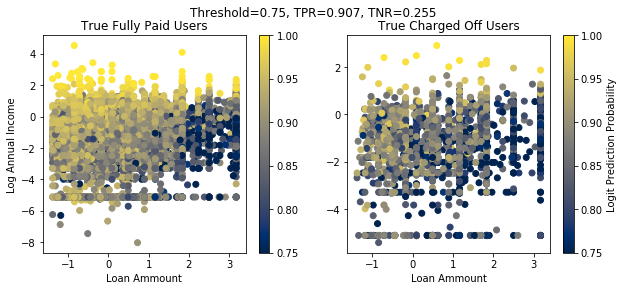

In [5]:
#The following plot compares the Logit classification of Fully Paid vs. Charged Off users. 
#Brighter points indicate users that would be given higher chances to get the loan based in this model with the select threshold.
#%matplotlib notebook
import matplotlib.colors as colors

df_log_plot=df_log.copy()
df_log_plot['loan_status']=df['loan_status']
df_log_plot['logit_predict']=predict_withvs


fig,ax=plt.subplots(1,2,figsize=(10,4))
dff2=df_log_plot[df_log_plot['loan_status']=='Fully Paid']
plot2=ax[0].scatter(dff2['loan_amnt'],np.log(dff2['annual_inc']),c=dff2['logit_predict'],cmap='cividis')
cbar2 = plt.colorbar(plot2,ax=ax[0])
ax[0].set_ylabel('Log Annual Income')
ax[0].set_xlabel('Loan Ammount')
ax[0].set_title('True Fully Paid Users')

dff1=df_log_plot[df_log_plot['loan_status']=='Charged Off']
plot1=ax[1].scatter(dff1['loan_amnt'],np.log(dff1['annual_inc']),c=dff1['logit_predict'],cmap='cividis')
cbar1 = plt.colorbar(plot1,ax=ax[1])
cbar1.set_label('Logit Prediction Probability')
ax[1].set_xlabel('Loan Ammount')
ax[1].set_title('True Charged Off Users')


def update(threshold):
    plot1.set_norm(norm=colors.Normalize(vmin=threshold,vmax=1.))

    
    plot2.set_norm(norm=colors.Normalize(vmin=threshold,vmax=1.))
  
    
    TPR=df_log_plot[(df_log_plot['loan_status']=='Fully Paid') & (df_log_plot['logit_predict']>=threshold)]['loan_status'].count()/df_log_plot[df_log_plot['loan_status']=='Fully Paid']['loan_status'].count()
    TNR=df_log_plot[(df_log_plot['loan_status']=='Charged Off') & (df_log_plot['logit_predict']<=threshold)]['loan_status'].count()/df_log_plot[df_log_plot['loan_status']=='Charged Off']['loan_status'].count()
    
    fig.suptitle('Threshold={:.2f}, TPR={:.3f}, TNR={:.3f}'.format(threshold,TPR,TNR))
    fig.canvas.draw_idle()

  
 #interact(update, threshold=(0,1,0.01));

update(0.75)  

We can also check the ROC curve and AUC of the model:

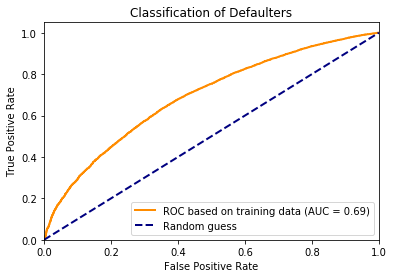

In [6]:
#%matplotlib inline

#Next we plot the ROC curve:
roc_vs = roc_curve(df['loan_status'].cat.codes, predict_withvs)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

These results seem ok. However, we have used all of our data set to create the model. How do we know if we are overfitting the model?

### Exercise 1: (10 min)

Generate the 10-fold cross-validation ROC curve (the average of all 10 ROC curves) and calculate the average AUC. For this, use the function `cv_roc` provided below. What are the values of `tprs`, `aucs`, and `mean_fpr` that are output by this function? Plot the cross-validation ROC curve, the training data ROC curve, and the random guess line on a single graph. Was our previous model having overfitting problems?

In [7]:
# generate cross-validated ROC and AUC for logistic regression model

def cv_roc(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train], X.iloc[train])
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

**Answer.** One possible solution is shown below:

First, `mean_fpr` is always equal to `np.linspace(0,1,100)` (that is, a list of 100 equidistant points in the interval $[0,1]$).
 
The list `tprs` contains the True Positive Rates (TPR) corresponding to thresholds having False Positive Rates (FPR) in `mean_fpr`. Notice that we used the function `np.interp` to interpolate the values output by the `roc_curve` function on each fold; this way, all the ROC curves are placed so that they have the same values across the $x$-axis. 

Finally, the list `aucs` contains the corresponding AUCs of each fold:

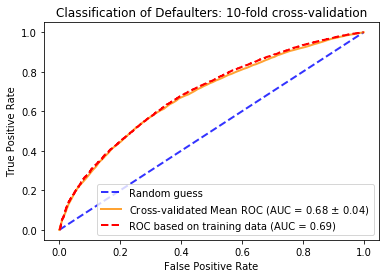

In [8]:
# plot the cross-validated ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc(df_log, df['loan_status'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Defaulters: 10-fold cross-validation')
plt.show()

We can see the average AUC is a bit smaller than the AUC calculated with training data. The difference is small, indicating the overfitting problem is not material in our case. The cross-validation ROC curve is also very close to the ROC curve generated with training data, further strengthening our contention that we do not have an overfitting problem.

Although logistic regression is one of the most commonly used classification algorithms, it is not the only one. If the underlying relationship between the logit of odds and the covariates is not linear, we need to consider higher order terms of the covariates to make the logistic model valid. Doing so requires a lot of tuning and experimenting. In such cases, it is often better to look at a classification algorithm that does not rely on a specific assumption about the relationship between the probability of the outcome and the covariates. One such model is the **Naive Bayes classifier**.

## The Naive Bayes classifier (80 min)

The classifier we will see next is based on a very simple but powerful result in statistics: Bayes' theorem! Before we dive deeper into the classifier, we will need some very basic notions of conditional probabilities. However, the idea of how the classifier operates is very simple:

> Given a client with certain characteristics, we will use Bayes' theorem and the observed data to estimate the probability that defaulters and non-defaulters have the same characteristics as the client. The larger of these two probabilities would then determine how we classify the client.

### Conditional probability and Bayes theorem (5 min)

Let $A$ and $B$ be a pair of events. For instance, think of $A$ as the event that a client is a defaulter and $B$ as the event that the client's income has been verified. The **conditional probability** of event $A$ given event $B$ is defined as the probability of observing event $A$ provided that event $B$ has already happened. Numerically, this means:

$$
\text{P($A$ given $B$)} =P(A|B)= \frac{\text{P($A$ and $B$)}}{\text{P($B$)}}.
$$

For our particular example, in words we have:

$$
\text{P( defaulter given verified income)=proportion of defaulters across all clients whose income has been verified.}
$$ 

Of course, there is nothing special about $A$ or $B$, so we can reverse them in the identity above to get:

$$
\text{P($B$ given $A$)} = \frac{\text{P($B$ and $A$)}}{\text{P($A$)}}.
$$

Notice that the numerators on the right-hand side of both equations are identical. Therefore, we can equate them and substitute in the remainder of each identity to get:

$$
\begin{align}
    \text{P($A$ given $B$)}\text{P($B$)} &= \text{P($B$ given $A$)}\text{P($A$)} \\
    \\
    \Rightarrow\text{P($A$ given $B$)} &= \frac{\text{P($B$ given $A$)}\text{P($A$)}} {\text{P($B$)}}
\end{align}
$$

This is the famous **Bayes' theorem**, upon which the Naive Bayes classifier is constructed.

### Exercise 2: (15 min)

#### 2.1 (4 min)

Use the data to estimate the values of $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$.


**Answer.** Here is one possible answer:

In [9]:
p_def=df[df['loan_status']=='Charged Off']['loan_status'].count()/df['loan_status'].count()
print('P(defaulter)={:.3f} \nP(non-defaulter)={:.3f}'.format(p_def, 1-p_def))

P(defaulter)=0.141 
P(non-defaulter)=0.859


#### 2.2 (4 min)

Use the definition of conditional probability and the data to estimate the probabilities

$$
\text{P(income verified given defaulter) and P(income verified given non-defaulter)}
$$


**Answer.** Here is one possible answer:

In [10]:
p_id=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()
print('P(income verified given defaulter)={:.3f} \nP(income verified given non-defaulter)={:.3f}'.format(p_id, p_ind))

P(income verified given defaulter)=0.363 
P(income verified given non-defaulter)=0.313


#### 2.3 (7 min)

Use Bayes' theorem to determine whether $\text{P(defaulter given income verified)}$ is larger than $\text{P(non-defaulter given income verified)}$.

**Hint:** You do not need to calculate $\text{P(income verified)}$ to solve this question.

**Answer.** Here is one possible answer:

Upon looking at Bayes' theorem, we see that $\text{P(defaulter given income verified)}$ and $\text{P(non-defaulter given income verified)}$ have the same denominator. Thus, in order to determine which one is larger we just need to determine whether:

$$
\text{P(income verified given defaulter)P(defaulter)>P(income verified given non-defaulter)P(non-defaulter)}
$$

Luckily, we have already computed these values in Exercises 2.1 and 2.2:

In [11]:
p_def_iv=p_id*p_def
p_ndef_iv=p_ind*(1-p_def)
print('P(defaulter given income verified)  is proportional to {:.3f}  \
\nP(non-defaulter given income verified) is proportional to {:.3f}'.format(p_def_iv, p_ndef_iv))

P(defaulter given income verified)  is proportional to 0.051  
P(non-defaulter given income verified) is proportional to 0.269


We can interpret our findings in the following way: if we only have information about the income verification status of our clients, we would probably give loans to those clients whose income has been verified. What happens if the client is either `Source Verified` or `Not Verified`? We can repeat the same procedure:

In [12]:
p_id2=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Source Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind2=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Source Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()

p_def_iv2=p_id2*p_def
p_ndef_iv2=p_ind2*(1-p_def)
print('P(defaulter given income source verified)  is proportional to {:.3f}  \
\nP(non-defaulter given income source verified) is proportional to {:.3f}'.format(p_def_iv2, p_ndef_iv2))

P(defaulter given income source verified)  is proportional to 0.037  
P(non-defaulter given income source verified) is proportional to 0.217


In [13]:
p_id3=df[(df['loan_status']=='Charged Off') & (df['verification_status']=='Not Verified')]['loan_status'].count()/df[df['loan_status']=='Charged Off']['loan_status'].count()
p_ind3=df[(df['loan_status']=='Fully Paid') & (df['verification_status']=='Not Verified')]['loan_status'].count()/df[df['loan_status']=='Fully Paid']['loan_status'].count()

p_def_iv3=p_id3*p_def
p_ndef_iv3=p_ind3*(1-p_def)
print('P(defaulter given income not verified)  is proportional to {:.3f}  \
\nP(non-defaulter given income not verified) is proportional to {:.3f}'.format(p_def_iv3, p_ndef_iv3))

P(defaulter given income not verified)  is proportional to 0.053  
P(non-defaulter given income not verified) is proportional to 0.373


The conditional probabilities of being a non-defaulter are always bigger than those for being a defaulter.

### Introducing the algorithm (10 min)

There are two possible routes that we can follow to create a classification algorithm from Bayes' theorem.

#### Probabilistic Model

Recall that in logistic regression, the main quantity of interest is the probability of no default (remember that our encoding was 1 for non-defaulters and 0 for defaulters) given specific values for the covariates. We explicitly modeled this probability as a linear function of covariates after transformation by the logit function. 

The Naive Bayes classifier aims to estimate this probability from a different perspective. From Bayes' theorem, we can express this conditional probability in the following way:

$$
\begin{equation}\tag{*}
\text{P(non-defaulter given covariates=values)} = \frac{\text{P(covariates=values given non-defaulter)P(defaulter)}}{\text{P(covariates=values)}}.
\end{equation}
$$

Then, we create our classifier as in the logistic model by selecting a threshold $t$ and classify a client with given covariates values as a defaulter if:

$$
\text{P(non-defaulter given covariates=values)}>t.
$$

#### Maximum A Posteriori Model (MAP)

For this classifier, a client with given covariates values is classified as a non-defaulter if:

$$
\text{P(non-defaulter given covariates=values)}>\text{P(defaulter given covariates=values)}
$$

which is equivalent to:

$$
\begin{equation}\tag{**}
\text{P(covariates=values given non-defaulter)P(non-defaulter)}>\text{P(covariates=values given defaulter)P(defaulter)}
\end{equation}
$$

Let's take a look at each of these quantities:

1. $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$. These are the probabilities of having a defaulter and a non-defaulter. These can be easily estimated using the proportion of defaulters in the dataset.
2. $\text{P(covariates=values)}$. This is the probability of having a customer whose covariates are equal to $\text{values}$. This can also be estimated by proportions, but we will actually find out that it is not necessary to estimate this quantity at all (more on this later).
3. $\text{P(covariates=values given non-defaulter)}$ and $\text{P(covariates=values given defaulter)}$. We can estimate these by looking at the proportion of defaulters and non-defaulters with covariates equal to $\text{values}$. But if we have a lot of covariates, the number of such defaulters might be extremely small or even equal to zero. The main challenge in building a Naive Bayes classifier is estimating these particular probabilities.

Indeed, when the number of covariates is large, it is hard to estimate $\text{P(covariates=values given non-defaulter)}$ by proportions directly. For instance, suppose that we have 10 covariates and that all of them are binary variables. Then, the total number of possible values these covariates can take is equal to $2^{10}=1024$. Thus, in order to estimate $\text{P(covariates=values given non-defaulter)}$ we would need at least $1024$ samples! If we want to go even further, suppose we want to classify texts having most 82 words, where each word in the text has 10 possible alternatives. The number of samples we would need will be larger than the number of atoms in the universe!

### Why is the classifier "naive"? (5 min)

As we have seen, we need a lot of samples to be able to estimate $\text{P(covariates=values given defaulter)}$ for all possible $\text{values}$ using observed proportions. In order to get around this problem, the Naive Bayes classifier makes the assumption that *all covariates are independent when conditioned on the outcome*. This assumption might never be true in the real world, which is why the method is called "naive". Nonetheless, it usually does not severely hamper the tool in practice and gives quite powerful results a lot of the time.

In our case, the assumption implies that within defaulters/non-defaulters, all covariates are independently distributed:

$$
\text{P(covariates=values given non-defaulter)} = \text{P(covariate}_1\text{=value}_1\text{ given non-defaulter)}\times\cdots\times\text{P(covariate}_p\text{=value}_p\text{ given non-defaulter)}
$$

Here we assume there are $p$ covariates in total. This significantly reduces the amount of samples required for the estimation! For instance, consider the example with 10 covariates, all of which are binary variables. Here, we need to estimate 10 simpler conditional probabilities and each one of them only concerns one binary variable, which has 2 possible outcomes. So we only need at least $2×10=20$ samples now, which is much smaller than $1024$.

### Exercise 3: (25 min)

#### 3.1 (10 min)

Using the available data, find a **naive** estimate of

$$
\text{P(term, verification_status given defaulter) and P(term, verification_status given non-defaulter)}
$$

for all different values of `term` and `verification_status`.

**Answer.** Shown below:

In [14]:
# First, we find the conditional probabilities of term and verification_status

df_default = df[df['loan_status']=='Charged Off']
df_ndefault=df[df['loan_status']=='Fully Paid']

#default
tpd=df_default['term'].value_counts()/df_default.shape[0]
vpd=df_default['verification_status'].value_counts()/df_default.shape[0]

#non-default
tpnd=df_ndefault['term'].value_counts()/df_ndefault.shape[0]
vpnd=df_ndefault['verification_status'].value_counts()/df_ndefault.shape[0]

#Then, we multiply the probabilities:
tv_default=pd.DataFrame(vpd.values.reshape(3,1).dot(tpd.values.reshape(1,2)),columns=tpd.index,index=vpd.index)
tv_ndefault=pd.DataFrame(vpnd.values.reshape(3,1).dot(tpnd.values.reshape(1,2)),columns=tpnd.index,index=vpnd.index)

print('Estimates given defaulter')
print(tv_default,'\n')
print('Estimates given non-defaulter')
print(tv_ndefault)  

Estimates given defaulter
                  36 months   60 months
Not Verified       0.212872    0.163966
Verified           0.205292    0.158127
Source Verified    0.146726    0.113017 

Estimates given non-defaulter
                  36 months   60 months
Not Verified       0.329195    0.105166
Verified           0.237173    0.075768
Source Verified    0.191516    0.061182


#### 3.2 (5 min)

Suppose that a client whose income has been verified asks for loan with a $60$-month payment plan. Use the Naive Bayes classifier (MAP version) to decide whether we should grant the client a loan or not.

**Answer.** Shown below:

In [15]:
tv_default*p_def

,36 months,60 months
Not Verified,0.029919,0.023046
Verified,0.028854,0.022225
Source Verified,0.020622,0.015885


In [16]:
tv_ndefault*(1-p_def)

,36 months,60 months
Not Verified,0.282926,0.090385
Verified,0.203838,0.065119
Source Verified,0.164598,0.052583


Using the results above we see that 

$$
\begin{equation}
\begin{aligned}
\text{P(term=60 months, verification_status=Verified given defaulter)P(defaulter)}&=0.022,\\ 
\text{P(term=60 months, verification_status=Verified given non-defaulter)P(non-defaulter)}&=0.065 ,
\end{aligned}
\end{equation}
$$

Thus, given our data, by looking solely at term and verification status we would still give the client the loan. Notice however that this model is again pretty useless - we will classify all clients as non-defaulters again.


#### 3.3 (10 min)

What happens with the same client if instead we use the Probabilistic Model with threshold $t=0.8$?


**Hint:** Use that 
$$
\text{P(term, verification_status)}=\text{P(term, verification_status given defaulter)P(defaulter)}+\text{P(term, verification_status given non-defaulter)P(non-defaulter)}
$$

**Answer.** 

First, we use Bayes' theorem to compute the probabilities $\text{P(defaulter given term, status_verification)}$:

In [17]:
ndefault_tv=tv_ndefault*(1-p_def)/(tv_default*p_def+tv_ndefault*(1-p_def))
ndefault_tv

,36 months,60 months
Not Verified,0.904364,0.796831
Verified,0.876000,0.745548
Source Verified,0.888660,0.767999


Thus, we have that :

$$
\text{P(non-defaulter given term=60 months, verification_status=Verified)}=0.74<0.8
$$

and we would classify this client as a defaulter. In fact we can see the performance of this new model by computing the ROC and AUC:

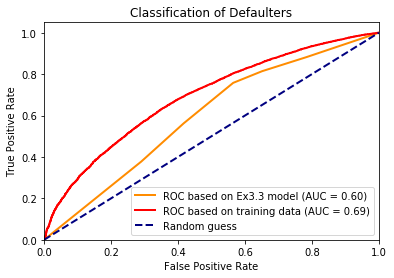

In [18]:
#%matplotlib inline

def predict_nb33(row):
    return ndefault_tv.loc[row['verification_status'],row['term']] #the index in default_tv has an extra space at beginning
    
df33=df.copy()
df33['predict_nb33']=df33.apply(predict_nb33,axis=1)
    
#Next we plot the ROC curve:
roc_vs33 = roc_curve(df33['loan_status'].cat.codes, df33['predict_nb33'])
auc_vs33 = auc( roc_vs33[0], roc_vs33[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs33[0], roc_vs33[1], color='darkorange', lw=line_width,
         label=f"ROC based on Ex3.3 model (AUC = {auc_vs33:0.2f})")
plt.plot(roc_vs[0], roc_vs[1], color='red', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

### What about continuous covariates? (5 min)

Computing proporitions works great for calculating the probabilities for discrete covariates. But what about variables like `annual_inc` that take on a continuous range of values? For these, we need to fit a *distribution* to the data. In the natural world, many things are governed by a normal distribution. To fit a normal distribution, all we need to specify is its mean and variance. The normal distribution with mean equal to the sample mean and variance equal to the sample variance of the covariate turns out to be a very good approximation. Once we get this normal distribution, the probabilities can be calculated directly for any covariate value.

**Note:** you should fit your data to a distribution that makes sense - there are plenty to pick from and your choice should be informed by the EDA that you perform prior to modeling.

### Exercise 4: (5 min)

Find the normal distribution that most aligned with the observed distribution of `annual_inc` in defaulters. Based on this normal distribution, calculate $\text{P(annual_inc=10,000 given defaulter)}$. Function `pdf()` in `scipy.stats.norm` 
calculates the density of a normal distribution at a given value.

**Answer.** Shown below:

In [19]:
mean_est = df_default['annual_inc'].mean()
var_est = df_default['annual_inc'].var()

# pdf takes standard deviation as scale parameter
# note we have log10 transformed annual_inc so when call norm.pdf, we should evaluate at 4
print(f"P(annual_inc=10,000 given defaulter) = {norm.pdf(10000, loc = mean_est, scale = np.sqrt(var_est))}")

P(annual_inc=10,000 given defaulter) = 4.473123137400818e-06


Once we have estimated all these single covariate conditional probabilities, we multiply them together to get our final estimate of $\text{P(covariates=values given non-defaulter)}$. Now, we claim that we can use the following procedure to get $\text{P(non-defaulter given covariates=values)}$:

1. Estimate $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$.
2. Estimate $\text{P(covariates=values given defaulter)}$ and $\text{P(covariates=values given non-defaulter)}$
3. Estimate $\text{P(non-defaulter given covariates=values)}$ with the following equation:

$$
    \frac{\text{P(covariates=values given non-defaulter)}\text{P(non-defaulter)}}{\text{P(covariates=values given defaulter)}\text{P(defaulter)}+\text{P(covariates=values given non-defaulter)}\text{P(non-defaulter)}}
$$

Let's pause a moment here and think about what the Naive Bayes estimator really does. From the step 3 we can see the conditional probability of default is indeed determined by the values of covariates through the conditional probabilities $\text{P(covariates=values given defaulter)}$ and $\text{P(covariates=values given non-defaulter)}$. The ratio between these two quantities reflects how different the distribution of covariates is in defaulters vs. non-defaulters. Effectively, Naive Bayes is comparing the distribution of covariates in groups of samples with different outcomes. This provides us a way to pre-screen for variables that should be included in the Naive Bayes classifier.

Let's visualize the distributions of covariates in our dataset, stratified by loan status, to get an idea of which should be included.

### Exercise 5: (10 min)

Use the `boxplot()` function in the `seaborn` package to visualize the distribution of the following continuous variables: `loan_amnt`, `annual_inc` and `int_rate` in defaulters and non-defaulters. Do you spot any differences in the distributions in defaulters and non-defaulters? Do these seem to satisfy the assumptions of the Naive Bayes classifier? If not, what should you do to get them to conform?

**Answer.** One possible solution is shown below:

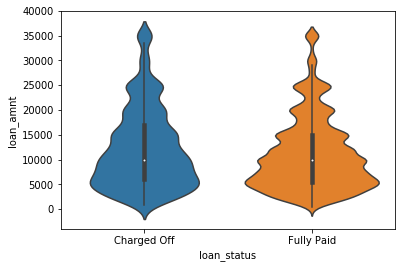

In [20]:
# plot the distribution of the continuous variable
sns.violinplot(x='loan_status', y='loan_amnt', data=df)

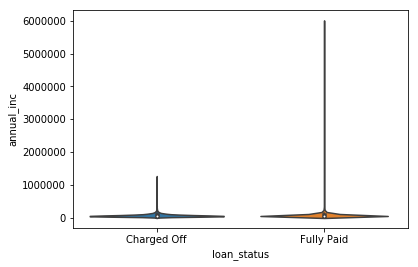

In [21]:
sns.violinplot(x='loan_status', y='annual_inc', data=df)

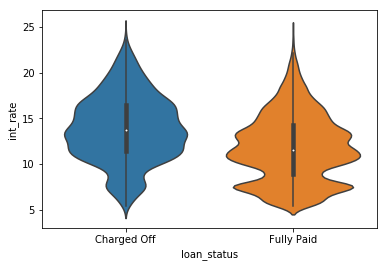

In [22]:
sns.violinplot(x='loan_status', y='int_rate', data=df)

We can see that the distribution of interest rate is different in the two types of users. The distribution of loan amount is also different, where non-defaulters tend to have more loans with small amounts (around 5000). The distributions of annual income seem to be heavily skewed, so let's apply a logarithmic transformation to see if we can get these to look more normal:

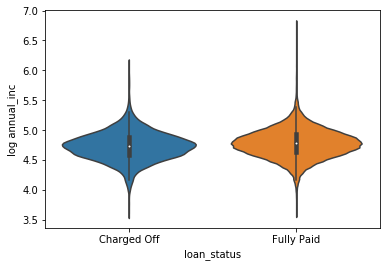

In [23]:
ax = sns.violinplot(x=df['loan_status'], y=np.log10(df['annual_inc']));
ax.set(ylabel='log annual_inc');

This is much better. The difference in annual income is not very large, but we can still see a slight increase in the mean of the annual income in non-defaulters compared to defaulters.

The distribution for `int_rate` is close enough to normal, but that of `loan_amnt` seems a bit skewed (although nowhere near the degree of `annual_inc`. Let's apply a square root transformation:

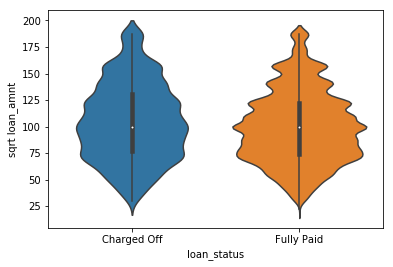

In [24]:
ax = sns.violinplot(x = df['loan_status'], y = np.sqrt(df['loan_amnt']));
ax.set(ylabel='sqrt loan_amnt');

This looks better.

From the above exercise, we find that we need to transform `annual_inc` and `loan_amnt` so that the normality assumption can be approximately satisfied. We will use the transformed variables to construct the Naive Bayes estimator:

In [25]:
df['annual_inc_log'] = np.log10(df['annual_inc'])
df['loan_amnt_sqrt'] = np.sqrt(df['loan_amnt'])

## Implementing the classifier (30 min)

### Using `sklearn.MultinomialNB` and `sklearn.GaussianNB` (10 min)

An implementation of the Naive Bayes classifier based on mixed categorical-continuous variables is not implemented in `sklearn` by default. However, by the *naive* independence assumptions of our classifier, it is possible to use the implementations for discrete (`sklearn.MultinomialNB`) and continuous (`sklearn.GaussianNB`) variables as follows. Suppose for the sake of simplicity that we want to estimate:
    
$$
\begin{align}
\text{P(non-defaulter given loan_amnt, term)},
\end{align}
$$

using

$$
\begin{equation}
\begin{aligned}
\text{P(non-defaulter given loan_amnt)} \quad \text{and} \quad \text{P(non-defaulter given term).}
\end{aligned}
\end{equation}
$$

By Bayes' theorem we have 

$$
\begin{align}
\text{P(non-defaulter given loan_amnt, term)}&=\frac{\text{P(term, loan_amnt given non-defaulter)P(non-defaulter)}}{\text{P(term, loan_amnt)}}, \\
&\approx \frac{\text{P(term given non-defaulter)P(loan_amnt given non-defaulter)P(non-defaulter)}}{\text{P(term)P(loan_amnt)}},\\
&=\text{P(non-defaulter)}\frac{\text{P(term given non-defaulter)}}{\text{P(term)}}\frac{\text{P(loan_amnt given non-defaulter)}}{\text{P(loan_amnt)}}, \\
&=\frac{\text{P(non-defaulter given term)}\text{P(non-defaulter given loan_amnt)}}{\text{P(non-defaulter)}}
\end{align}
$$

In simpler words, the naive independence assumption allows us to compute the probabilities by first fitting a model for the discrete variables and continuous variables separately. We then multiply these values and divided by the prior probabilities $\text{P(non-defaulter)}$ and $\text{P(defaulter)}$.

As an example, let's fit a Naive Bayes classifier using the covariates `term`, `verification_status`, `loan_amnt_sqrt` and  `annual_inc_log`:

In [26]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

df_nb=df.copy()

#encode the categorical variables:
for var in ['loan_status', 'term','verification_status']:
    df_nb[var]=df_nb[var].cat.codes

#we fit the model for continuous variables
y=df_nb['loan_status']
Xcont=df_nb[['annual_inc_log','loan_amnt_sqrt']]
gnb = GaussianNB()
cont_probas=gnb.fit(Xcont, y).predict_proba(Xcont)

#we fit the model for categorical variables
Xcat=df_nb[['term','verification_status']]
mnb=MultinomialNB()
cat_probas=gnb.fit(Xcat, y).predict_proba(Xcat)


#multiply the probabilites and divide by priors
nb_probas=np.multiply(cont_probas, cat_probas)/np.array([p_def, 1-p_def])

#add probabilities to the data frame
df_nb['nb_predict_proba']=nb_probas[:,1]
df_nb['nb_predict_proba']

0        0.862240
1        0.726892
2        0.850376
3        0.901779
4        0.760862
5        0.895369
6        0.770254
7        0.906168
8        0.739287
9        0.671778
10       0.784943
11       0.914291
12       0.882028
13       0.851721
14       0.929311
15       0.884945
16       0.907100
17       0.950389
18       0.912871
19       0.933867
20       0.677950
21       0.884881
22       0.902458
23       0.914677
24       0.937307
25       0.899067
26       0.908764
27       0.773669
28       0.949393
29       0.874454
           ...   
38675    0.926670
38676    0.929146
38677    0.869727
38678    0.916879
38679    0.921303
38680    0.975633
38681    0.858536
38682    0.960827
38683    0.945769
38684    0.854903
38685    0.887205
38686    0.936250
38687    0.902203
38688    0.829465
38689    0.936681
38690    0.899284
38691    0.968510
38692    0.889178
38693    0.953694
38694    0.966349
38695    0.966349
38696    0.919775
38697    0.939630
38698    0.941826
38699    0

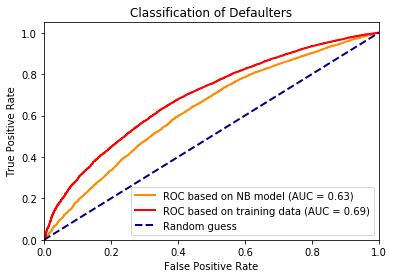

In [27]:
roc_nb= roc_curve(df_nb['loan_status'], df_nb['nb_predict_proba'])
auc_nb= auc( roc_nb[0], roc_nb[1] )

plt.figure()
line_width = 2
plt.plot(roc_nb[0], roc_nb[1], color='darkorange', lw=line_width,
         label=f"ROC based on NB model (AUC = {auc_nb:0.2f})")
plt.plot(roc_vs[0], roc_vs[1], color='red', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

### Implementing our own classifier (20 min)

We have seen that in order to estimate the classifier, we need to estimate the normal distribution that can be fit to each variable, then use this to estimate the probabilities we need. The below function `nb_fit_con()` will accomplish the first task:

In [28]:
"""
Learn parameters for continuous covariate
y is a binary outcome
X is a pandas series of a continuous covariate
"""
def nb_fit_con(y, X):
    y_code = y.cat.codes
    X_0 = X[y_code==0]
    X_1 = X[y_code==1]
    return [[np.mean(X_0), np.std(X_0)], [np.mean(X_1), np.std(X_1)]]

Next, we write a function `nb_fit_dis` to estimate the probabilities of each level of a discrete covariate in defaulters and non-defaulters:

In [29]:
"""
Learn parameters for discrete covariate
y is a binary outcome
X is a pandas series of a discrete covariate
"""
def nb_fit_dis(y, X):
    y_code = y.cat.codes
    X_code = X.cat.codes
    X_nlvl = len(X.cat.categories)
    
    X_0 = X_code[y_code==0]
    X_1 = X_code[y_code==1]
    
    X_0_freq = [np.sum(X_0==x)/len(X_0) for x in range(X_nlvl)]
    X_1_freq = [np.sum(X_1==x)/len(X_1) for x in range(X_nlvl)]
    return [X_0_freq, X_1_freq]

The following function uses the two estimation functions we wrote above to train a Naive Bayes classifier:

In [30]:
"""
y is a binary outcome
X is a pandas dataframe of covariates
"""
def train_nb_classifier(y, X):
    trained_model = {}
    for ind_col in X.columns:
        # check data type
        if X[ind_col].dtype=='float':
            params_fit = nb_fit_con(y, X[ind_col])
        else:
            params_fit = nb_fit_dis(y, X[ind_col])
        trained_model[ind_col] = params_fit
    margin_p_0 = np.sum(y.cat.codes==0)/len(y)
    trained_model['margin_p'] = [margin_p_0, 1-margin_p_0]
    return trained_model

Once the model is trained, the following function `predict_nb_classifier` predicts the probability of not defaulting for new samples:

In [31]:
"""
log of normal density
"""
def log_dnorm(x, loc, scale):
    return -(x-loc)**2/2/(scale**2) - np.log(scale) - 0.5*np.log(2*np.pi)

"""
prediction
X_test: a pandas dataframe of covariates for prediction
        discrete vars have the same coding scheme as in the train dataset
"""

def predict_nb_classifier( nb_fit, X_test ):
    pred_0_p = np.ones(X_test.shape[0] )*np.log(nb_fit['margin_p'][0])
    pred_1_p = np.ones(X_test.shape[0] )*np.log(nb_fit['margin_p'][1])
    
    for ind_col in X_test.columns:
        params = nb_fit[ind_col]
        if X_test[ind_col].dtype=='float':
            #increment prob for outcome 0 for all samples
            update_0 = log_dnorm(X_test[ind_col], loc = params[0][0], scale = params[0][1])
            update_1 = log_dnorm(X_test[ind_col], loc = params[1][0], scale = params[1][1])
        else:
            update_0 = [np.log(params[0][x]) for x in X_test[ind_col].cat.codes]
            update_1 = [np.log(params[1][x]) for x in X_test[ind_col].cat.codes]
        pred_0_p = pred_0_p + update_0
        pred_1_p = pred_1_p + update_1
    
    #calculate the estimated probability of outcome=1
    #specifically handle Inf
    p_ratio = np.exp(pred_1_p-pred_0_p)
    p_1 = p_ratio/(1+p_ratio)
    p_1[p_ratio==np.Inf] = 1
    
    return p_1

### Exercise 6: (10 min)

Use functions `train_nb_classifier` and `predict_nb_classifier` to write a function to generate ROC curve and calculate AUC  for NB classifier with `n_split`-fold cross validation (refer to `cv_roc` for a template). The input should be `X`, the matrix of covariates, `y`, the vector of outcomes and `n_split`, the number of folds. The output is the same 3-tuple as function `cv_roc`, where the first element is the list of true positive rates across all `n_split` folds, the second element is a list of AUCs and the third element is a list of mean false positive rate which is set to be `np.linspace(0, 1, 100)`.  Use this function on the NB classifer with covariate `term`, `verification_status` and `annual_inc`. Compare this to the logistic model using the same set of covariates.

**Answer.** One possible solution is shown below:

In [32]:
def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        nb_trained = train_nb_classifier(y.iloc[train], X.iloc[train])
        probas_ = predict_nb_classifier(nb_trained, X.iloc[test])
        
        # Compute ROC curve and area the curve
        
        fpr, tpr, thresholds = roc_curve(y.iloc[test].cat.codes, probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

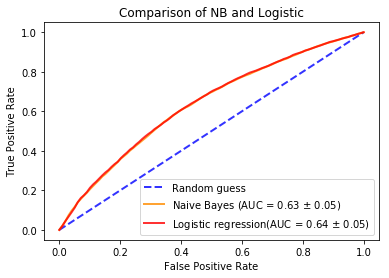

In [33]:
# fit NB
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb(df[['term', 'verification_status', 'annual_inc_log']], df['loan_status'], 5)

# fit logistic
tprs_lgs, aucs_lgs, mean_fpr_lgs = cv_roc(df_log[['Intercept', 'term', 'verification_status', 'annual_inc']], df['loan_status'].cat.codes, 5)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_lgs = np.mean(tprs_lgs, axis=0)
mean_tpr_lgs[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
mean_auc_lgs = auc(mean_fpr_lgs, mean_tpr_lgs)
std_auc_lgs = np.std(aucs_lgs)

plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange', lw=2, alpha=.8,
         label=f"Naive Bayes (AUC = {mean_auc_nb:0.2f} $\pm$ {std_auc_nb:0.2f})")
plt.plot(mean_fpr_lgs, mean_tpr_lgs, color='red', lw=2, alpha=.8,
         label=f"Logistic regression(AUC = {mean_auc_lgs:0.2f} $\pm$ {std_auc_lgs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Comparison of NB and Logistic')
plt.show()

From this, we can see that the Naive Bayes classifier has a slightly lower AUC than the corresponding logistic model. This might be due to the fact that these three covariates are highly correlated (as we have seen in the previous case). But the difference is not very large and will be further refined with covariate choice. However, as you probably noticed, the implementation of Naive Bayes is quite math-heavy and relies on a simplifying assumption of independence. This makes Naive Bayes bad when covariates are obviously dependent.
    
For example, let us pretend we are trying to classify if someone has more than 5 aunts and uncles. We have two covariates: `num_dad_siblings` and `num_mom_siblings`. Obviously the classifcation should be to add the two and see if it is greater than 5. But, Naive Bayes assumes they are unrelated and produces classifications that do not check the sum of the two. Luckily for us, there are other classifiers that can find these type of relationships.

## Decision trees and random forests (50 min)

Let's now discuss the **decision tree classifier**. The following figure shows an example. The nodes at the very bottom of the tree are called leaf nodes and all other nodes are called internal nodes or branch nodes. Each node contains a specific amount of samples that is indicated by `samples=`. Among these samples, the proportion of samples that are defaulters and non-defaulters are indicated by `value=`. The majority outcome values are indicated by `class=`.

When you want to predict the default status of a particular sample data point, you start with the top-most node. This internal node tells you which direction to go based on the value of `annual_inc`. Following the instructions in the internal nodes, you traverse the tree until you encounter a leaf node. The outcome label at that leaf node is then the predicted outcome for this sample. This whole prediction process is very much like what we do in our daily life when making a decision (based on the answer to a particular question, make a choice about what question to answer next and after enough answers, arrive at a conclusion).

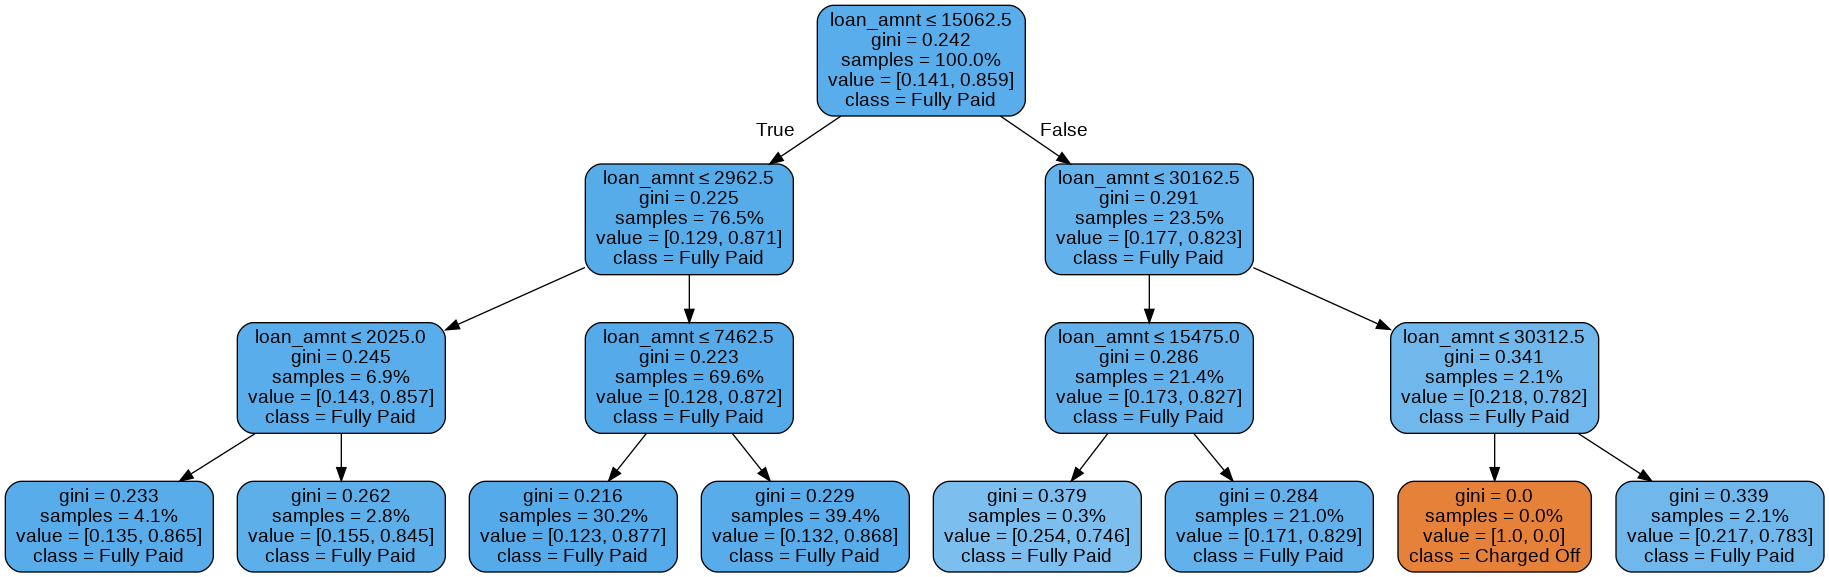

In [34]:
# NOTE: If you are using Docker please open a terminal and run the following command:
#         conda install graphviz
#       prior to running this cell.
# If you are on Windows, OSX or Linux, and not using Docker 
# install graphviz in your machine and add its bin folder to your PATH
# You can follow the appropiate instructions for your OS
df_t=df.copy()
for var in ['loan_status', 'term','verification_status','grade','home_ownership']:
    df_t[var]=df_t[var].cat.codes


clf = DecisionTreeClassifier(max_depth = 3)

# Train Decision Tree Classifer
covariates=['loan_amnt']

clf = clf.fit(df_t[covariates], df_t['loan_status'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates,
                class_names=['Charged Off', 'Fully Paid'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

If you have trouble running the above cell, this is the expected output.
![](tree-1.png)

### Exercise 7: (5 min)

Assume you have two users with `loan_amnt` equal to 10,000 and 100,000,000 respectively. What are the predicted default status for these two users, using the decision tree above?

**Answer.** For the first user, we go left, right, and right. The leaf node contains 2013 defaulters and 13229 non-defaulters. So we predict that this user will be a non-defaulter. For the second user, we go right, right, and right again. The predicted outcome for this user is also non-defaulter.

### How does the algorithm work? (15 min)

Suppose that we want to create a decision tree that predicts `loan_status` based on `term` and `verification_status`. The first thing we should do is decide which node to put at the top of the tree. We can do this by simply determining which of `term` and `verification_status` does a better job of predicting `loan_status`. 

For instance, imagine that the top node in the tree is `term<0.5` (that is, if the client asked for a loan with a `36 month` term). Ideally, this would be a perfect classifier if every client that asked for a `36 month` term loan fully paid off their debt and every client that did not ask for a `36 month` term loan defaulted. Clearly, this is not the case:

In [35]:
def get_ct(df, col):
    ct_res = pd.crosstab(col, df['loan_status'], margins=True)
    ct_res["Fully Paid(%)"] = ct_res[1]/ct_res["All"]
    return ct_res

get_ct(df_t,df_t['term']<0.5)

loan_status,0,1,All,Fully Paid(%)
term,,,,
False,2367,8054,10421,0.772862
True,3073,25211,28284,0.891352
All,5440,33265,38705,0.859450


Across all clients that asked for a `36 month` term loan, 89.1% are non-defaulters. Because not all clients were all defaulters or all non-defaulters, we say that this set is **impure**. For example, the set of clients that asked for a `60 month` term loan is also impure as only 77.2% of these are non-defaulters. Rather that find a perfect rule that isolates a pure set, the main goal of the algorithm is to select a rule that minimizes the overall impurity of the resulting sets.

One popular method to measure the impurity of a set is to use the so-called **Gini impurity**:

$$
\begin{equation}
\begin{aligned}
\text{Gini}(\text{'term'}<0.5)=2(0.891)(1-0.891)\approx 0.193.\\
\text{Gini}(\text{'term'}\geq 0.5)=2(0.772)(1-0.772)\approx 0.351.\\
\end{aligned}
\end{equation}
$$ 

Then the overall impurity of the decision `term`<0.5 is calculated as:

$$
\text{CART('term'<0.5)}=\frac{\text{Clients with term<0.5}}{\text{All clients}}\text{Gini}(\text{'term'}<0.5)+\frac{\text{Clients with term>0.5}}{\text{All clients}}\text{Gini}(\text{'term'}<0.5)\approx 0.23606
$$

Let's calculate the overall impurity of the decisions `verified_source`<0.5 (i.e. clients that are `Not Verified`) and `verified_source`<1.5 (i.e. clients that are `Not Verified` or `Source Verified`):

In [36]:
ct=get_ct(df_t,df_t['verification_status']<0.5)
GiniTrue=2*ct.loc[True,'Fully Paid(%)']*(1-ct.loc[True,'Fully Paid(%)'])
GiniFalse=2*ct.loc[False,'Fully Paid(%)']*(1-ct.loc[False,'Fully Paid(%)'])
CART=(ct.loc[True,'All']*GiniTrue+ct.loc[False,'All']*GiniFalse)/ct.loc['All','All']
print('Overall inpurtity of `verification_status`<0.5 is ', CART)

Overall inpurtity of `verification_status`<0.5 is  0.241197018572


In [37]:
ct=get_ct(df_t,df_t['verification_status']<1.5)
GiniTrue=2*ct.loc[True,'Fully Paid(%)']*(1-ct.loc[True,'Fully Paid(%)'])
GiniFalse=2*ct.loc[False,'Fully Paid(%)']*(1-ct.loc[False,'Fully Paid(%)'])
CART=(ct.loc[True,'All']*GiniTrue+ct.loc[False,'All']*GiniFalse)/ct.loc['All','All']
print('Overall inpurtity of `verification_status`<1.5 is ', CART)

Overall inpurtity of `verification_status`<1.5 is  0.241250148572


Thus, the decision that gives the lowest impurity score is `term<0.5` and this is the node from which we start our decision tree. Finally, we repeat this procedure with the subsequent subsets determined by the decision `term<0.5` until the desired depth has been reached or all subsequent sets have zero impurity. For the sake of completeness, we can check our findings using the `sklearn` decision tree classifier:

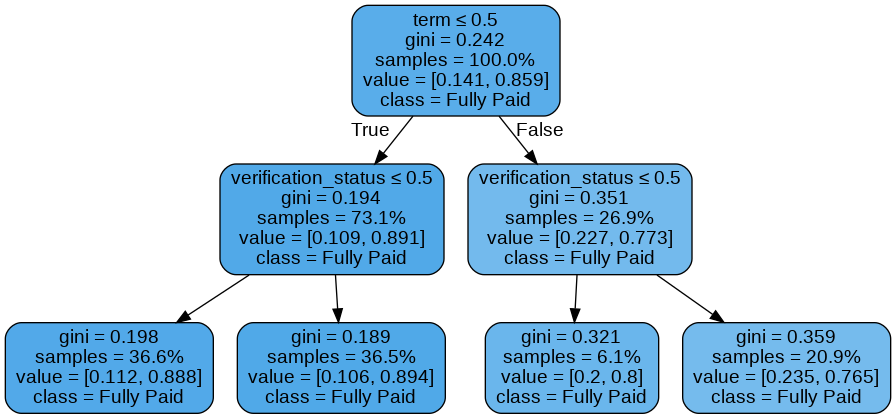

In [38]:
clf2 = DecisionTreeClassifier(max_depth = 2)

# Train Decision Tree Classifer
covariates=['term','verification_status']

clf2 = clf2.fit(df_t[covariates], df_t['loan_status'])

dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data, feature_names = covariates,
                class_names=['Charged Off', 'Fully Paid'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

If you have trouble running the above cell, this is the expected output.
![](tree-2.png)

We can see the decision tree approach does not put any assumption on the relationship between the outcome and the covariates. Therefore, it is a very flexible algorithm that can capture a wide range of underlying relationships between the outcome and the covariates. Nevertheless, this algorithm has many drawbacks:

1. Because it is so flexible, it tends to overfit. When applied to an independent validation set, the performance often decreases significantly. This drawback really limits the application of decision trees.
2. It is hard to train when the number of covariates are large. At each internal node, you need to scan through a long list of potential splitting variables, thus making the algorithm computationally cumbersome. However, this issue has been mitigated with modern computing power.
3. Decision trees trained on the same dataset are not always the same. This instability issue happens because the algorithm may not scan through the covariates in the same order every time. As a result, the final tree can vary a lot from run to run.

### Exercise 8: (10 min)

Use `train_test_split` function from `sklearn` package, randomly select 75% of the sample in our dataset and train a decision tree on these samples with covariate `annual_inc`. Evaluate the accuracy of the tree on the training set and samples that are not included in the training set. Do you see a significant change in the accuracy score?

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df[['loan_amnt']],
                                                    df['loan_status'].cat.codes, test_size=0.25,
                                                    random_state=1)
clf_new = DecisionTreeClassifier()
clf_new = clf_new.fit(X_train, y_train)

y_pred_train = clf_new.predict(X_train)
y_pred_test = clf_new.predict(X_test)

print(f"Accuracy in training set: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(y_test, y_pred_test)}")

Accuracy in training set: 0.8617886178861789
Accuracy in the other samples: 0.8524336054562365


**Answer.** We can see the accuracy drops 0.1 in the other samples. This seems to indicate the overfitting problem of our particular decision tree is not too severe. But we should keep in mind that the prevalence of non-defaulters in the dataset is much higher than that of defaulters. This might inflate the accuracy of an otherwise mediocre classifer. (To see an example of this, consider a naive classifier which labels everyone a non-defaulter. This classifier would be right the vast majority of the time, yet we would hardly consider it to be a nuanced classifier.)

### Decision boundary of a decision tree (5 min)

The decision boundary of decision tree can be highly non-linear. It usually looks like patches due to the fact that we are dichotomizing the dataset at multiple levels. The following is an example for a tree built with `annual_inc` and `loan_amnt`:

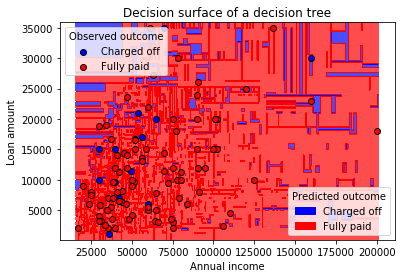

In [40]:
n_classes = 2
plot_colors = 'br'

labels = ['Charged off', 'Fully paid']

clf = DecisionTreeClassifier().fit(df[['annual_inc', 'loan_amnt']], df['loan_status'].cat.codes)

# Plot the decision boundary

plot_step = 100
viridis = cm.get_cmap('viridis', 2)
newcolors = viridis(np.linspace(0, 1, 2))
blue = np.array([0, 0, 1, 1])
red = np.array([1, 0, 0, 1])
newcolors[0, :] = blue
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)

np.random.seed(0)
idx_plot = np.random.choice(df.shape[0], 100, replace = False )
df_plot = df.iloc[idx_plot]

x_min, x_max = df_plot['annual_inc'].min() - 1000, df_plot['annual_inc'].max() + 1000
y_min, y_max = df_plot['loan_amnt'].min() - 1000, df_plot['loan_amnt'].max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=newcmp, alpha = 0.7)

plt.xlabel('Annual income')
plt.ylabel('Loan amount')
plt.axis('tight');

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(df_plot['loan_status'].cat.codes == i)
    plt.scatter(df_plot.iloc[idx]['annual_inc'], df_plot.iloc[idx]['loan_amnt'], c=color, 
                label=labels[i], edgecolors='black')

legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Charged off'),
                   Patch(facecolor='red', edgecolor='red', label='Fully paid')]

plt.axis('tight')
plt.title('Decision surface of a decision tree')
leg1 = ax.legend(loc='upper left', title='Observed outcome')
ax.legend(handles=legend_elements, loc='lower right', title='Predicted outcome');
ax.add_artist(leg1);

### Random forest to improve the performance of decision tree (15 min)

**Random forests** might well be the most popular machine learning algorithm for both classification and regression. The idea behind random forests is to construct a lot of decision trees, then use a voting mechanism to produce a final prediction that is agreed upon by most of the decision trees. When training these individual trees, we also subsample on the dataset as well as the covariates that are available in order to get as much built-in cross-validation as possible. As a result, the problem of overfitting and stability in a single decision tree model is resolved to a large degree. Let's fit a random forest classifier with covariates `term` and `annual_inc` and generate its ROC curve using the training data:

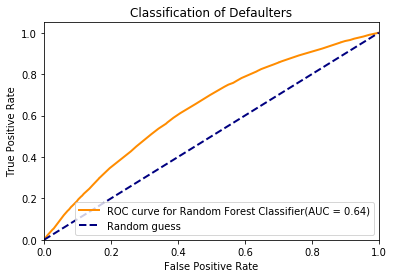

In [41]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_rf.fit(df_log[['annual_inc', 'term']], df['loan_status'].cat.codes)
clf_rf_probas = clf_rf.predict_proba(df_log[['annual_inc', 'term']])

roc_p = roc_curve(df['loan_status'].cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

### Exercise 9: (10 min)

Use `cv_roc` as the template (same input arguments plus an argument `algo` determining decision tree or random forest, same output) to write a function `cv_roc_tree` that generates a 5-fold cross-validation ROC for a decision tree model and a random forest model with covariates `term` and `annual_inc`. Do you spot a significant increase in the prediction performance of the random forest model compared to the decision tree model?

In [42]:
def cv_roc_tree(X, y, n_split, algo='Tree'):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        else:
            clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

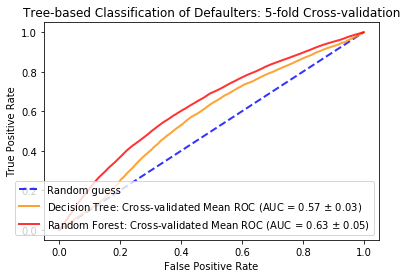

In [43]:
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(df_log[['term', 'annual_inc']], df['loan_status'].cat.codes, 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(df_log[['term', 'annual_inc']], df['loan_status'].cat.codes, 5, algo='forest')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Tree-based Classification of Defaulters: 5-fold Cross-validation')
plt.show()

**Answer.** We can see there is an increase in AUC using the random forest algorithm. With only two covariates, we can achieve a rather significant increase in the performance. This difference would likely be more pronounced with more variables.

## Selecting the best model for predicting default status (10 min)

So far we have learned about four different classification models, their strengths and weaknesses, and how to impelement them. We are also equipped with a powerful model comparison tool, cross-validation, to get an objective evaluation for a classification model. Let's now construct all three models (we'll leave out decision tree for now, and just use random forest as both belong to the family of tree-based models) using all of our covariates. We want to compare their cross-validation ROC curves and AUC values to decide which should be the one that forms the user selection procedure for our company:

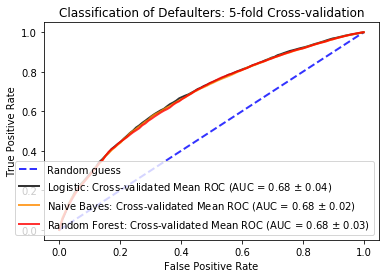

In [44]:
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb(df.drop(['loan_status', 'loan_amnt', 'annual_inc'], axis=1), df['loan_status'], 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(df_log.drop('Intercept', axis=1), df['loan_status'].cat.codes, 5, algo='forest')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_nb = np.std(aucs_nb)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='black', lw=2, alpha=.8,
         label=f"Logistic: Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")
plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange', lw=2, alpha=.8,
         label=f"Naive Bayes: Cross-validated Mean ROC (AUC = {mean_auc_nb:0.2f} $\pm$ {std_auc_nb:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Defaulters: 5-fold Cross-validation')
plt.show()

### Which one to use? (5 min)

When deciding which model to use, the gold standard should always include the prediction performance; e.g. AUC. Based on the results above, all the models have the same performace. In such a scenario, we tend to go with the model that has the least variance, which in this case would be the Naive Bayes.

However, there are many other factors one should consider when choosing between models:

1. Purpose of the analysis. If a quick and dirty classifier is what we want, random forests work relatively well with their default settings. If your data follows some well understood patterns, encoding them into a Naive Bayes classifier might be worth it.
2. Number of data points. In the era of big data it is common to encounter datasets with an enormous amount of samples. Since logistic regression is fit via an optimization routine, it can get very slow when the amount of data is large. Random forests also take longer to train with more data. The Naive Bayes classifier does not have this problem as it only calculates means and variances and is extremely fast even for large datasets.
3. Number of covariates. As the number of covariates increases, the computational burden of logistic regression and random forests grows much faster than linearly. Naive Bayes does not have this problem (it scales linearly with the number of covariates) and should be considered as a strong candidate in this case.

In our case, the dataset has less than 40,000 samples and only 9 covariates, this makes all 3 viable choices. In the future, if the amount of data required to be processed increases dramatically, we can have an interesting tradeoff to consider. With more data, the logistic and random forest classifiers will benefit from the additional data as this should elevate their AUC and reduce their variance. However, if the data quantity increases dramatically, we can start to see computation time go through the roof for training. If computation time becomes an issue, one could subsample and use random forests or logistic classification, or use Naive Bayes on the complete data set.

To further complicate things, the reason why random forest has a 0.68 AUC in this final version is because we used `depth=3` instead of `depth=2` which got a AUC of 0.64. So, you need not only pick a classifier, you need to pick the right parameters. One may be tempted to increase the depth, but this only exponentially increases training time and may actually yield worse results.

To summarize, picking a classifier is not a clear and easy decision, but these guidelines give you a place to start.

## Conclusions (4 min)

In this case, we learned about a few new classification models and the advantages and disadvantages they have versus the standard logistic model. We learned that the Naive Bayes classifier, although "naive", generally does not suffer much and in fact is the fastest to train. On the flip side, tree-based models and particularly random forest are able to capture many non-linear relationships and interactions in our data, but are much slower to train. We then used cross-validation to select the model that has the best performance among the types of models we have learned so far.

In the end, we discovered that all the models performed nearly identically. This is partially due to the fact that the data set is of medium size (on the order of $10^4$) and the number of covariates is relatively small. There is enough data that random forests and logistic regression don't overfit and the number of covariates is small enough that they can be trained fairly quickly. It should be noted that Naive Bayes had the lowest variance, showing that it is naive in name only. In some problems, it may very well be the best classifier.

## Takeaways (5 min)

In this case, we introduced the concepts of **Naive Bayes**, **decision tree**, and **random forest** classifiers and compared their performance using **cross validation**. We did this by:

1. Building a baseline classifier using logistic regression
2. Deriving the Naive Bayes classifier and implementing it
3. Introducing decision trees and extending them to a random forest
4. Assessed classifier performance using AUC and implementing our own cross validation

Logistic regression, Naive Bayes, and tree-based models (decision trees and random forests) are all great classification models that each have their strengths and weaknesses. Cross-validation is an especially good way of evaluating the effectiveness of these models side-by-side.
    
While these classifiers represent the majority of classifiers out there, each one has its own set of extensions. For example, the Naive Bayes classifier can assume distributions other than the normal distribution. Random forests are notorious for requiring specific tuning of its parameters depending on the problem at hand, opening up a whole set of extensions. One can also build ensemble models where you train multiple models and each one gets a "vote" in the final classification of each data point, and the ensemble model assigns to each data point the class with the most "votes".